# FunC-ESMs training and validation

Paper title: Decoding molecular mechanisms for loss of function variants in the human proteome

Authors: Matteo Cagiada, Nicolas Jonsson and Kresten Lindorff-Larsen

Correspondence to: K.L.-L. (lindorff@bio.ku.dk)

Notebook by: Matteo Cagiada (matteo.cagiada@bio.ku.dk)

## Functions

In [1]:
import numpy as np ## numpy 1.26.4
import os,sys
import pandas as pd ## pandas 2.2.1
import scipy as sp ## scipy 1.12.0
from scipy import stats

import matplotlib as mpl ## matplotlib 3.8
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
 
from glob import glob

from sklearn.metrics import roc_curve, auc, classification_report ## skiti-learn 1.3.0
from sklearn.model_selection import RepeatedStratifiedKFold

import warnings
warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.labelsize']  = 16
mpl.rcParams['legend.fontsize'] = 14

In [3]:
alphabetAA_L_D={'-':0,'_' :0,'A':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'K':9,'L':10,'M':11,'N':12,'P':13,'Q':14,'R':15,'S':16,'T':17,'V':18,'W':19,'Y':20}
alphabetAA_D_L={v: k for k, v in alphabetAA_L_D.items()}
               
alphabetAA_3L_1L={"Ter":'*',"Gap":'-',"Ala":'A',"Cys":'C',"Asp":'D',"Glu":'E',"Phe":'F',"Gly":'G',"His":'H',"Ile":'I',"Lys":'K',"Leu":'L',"Met":'M',"Asn":'N',"Pro":'P',"Gln":'Q',"Arg":'R',"Ser":'S',"Thr":'T',"Val" :'V',"Trp":'W',"Tyr":'Y'}
alphabetAA_1L_3L={v: k for k,v in alphabetAA_3L_1L.items()}

alphabetAA_L_D_reordered={0:'R',1:'H',2:'K',3:'D',4:'E',5:'S',6:'T',7:'N',8:'Q',9:'C',10:'G',11:'P',12:'A',13:'V',14:'I',15:'L',16:'M',17:'F',18:'Y',19:'W'}
alphabetAA_D_D_reordered={14:0,6:1,8:2,2:3,3:4,15:5,16:6,11:7,13:8,1:9,5:10,12:11,0:12,17:13,7:14,9:15,10:16,4:17,19:18,18:19}

In [4]:
def normalize_cutoff(scores,lowcut,highcut):
    normalized_scores=np.copy(scores)
    for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
            if scores[i,j] < lowcut:
                normalized_scores[i,j]=lowcut
            elif scores[i,j] > highcut:
                normalized_scores[i,j]=highcut
            else:
                normalized_scores[i,j]=scores[i,j]
    return normalized_scores

In [5]:
def load_data(data,wt_seq,start_gap=0,column_score=1):
    df=pd.read_csv(data, delim_whitespace=True, comment='#')
    mutation_load=np.array(df.iloc[:,0])
    score_load=np.array(df.iloc[:,column_score])
    scores=np.empty((len(wt_seq),20),dtype=float)
    scores[:]=np.nan
    for i in range(len(mutation_load)):
        if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][len(mutation_load[i])-1]!= '*':
            scores[int(mutation_load[i][1:len(mutation_load[i])-1])-1+start_gap, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]= float(score_load[i])
    return scores

In [6]:
def prism_extract_WT_sequence(file_pred):
    header_parse = pd.read_csv(file_pred, sep='#', skipinitialspace=True, header=None)
    hd = header_parse.iloc[:, 1].dropna()
    
    return hd[6].split()[1]

In [7]:
def esms_model_variant_classes(esm1b_score,esmif_score,esm1b_t=-8.07,esmif_t=-8.94):
    
    assert esm1b_score.shape[0] == esmif_score.shape[0], "shapes of input scores don't match!"
    
    esms_v_class=np.empty((esm1b_score.shape[0]),dtype=float)
    esms_v_class[:]=np.nan
    
    for i in range(esms_v_class.shape[0]):
        if np.isnan(esm1b_score[i]) or np.isnan(esmif_score[i]):
            continue
            
        else:
            if esm1b_score[i] > esm1b_t:
                esms_v_class[i]=0
            else:
                if esmif_score[i] > esmif_t:
                    esms_v_class[i]=1
                else:
                    esms_v_class[i]=2
    
    return esms_v_class
    

In [8]:
def multiclass_threshold(data_abund,data_funct,t_x,t_y):
    labels=np.copy(data_abund)
    labels[:]=np.nan
    
    for i in range(data_abund.shape[0]):
        for j in range(data_abund.shape[1]):
            if np.isnan(data_abund[i,j])!= True and np.isnan(data_funct[i,j])!=True:
                if data_abund[i,j] > t_x and data_funct[i,j]<t_y:
                    labels[i,j]=1
                elif data_abund[i,j] < t_x and data_funct[i,j]<t_y:
                    labels[i,j]=2
                elif data_abund[i,j] < t_x and data_funct[i,j]>t_y:
                    labels[i,j]=np.nan
                else:
                    labels[i,j]=0
    
    return labels

In [9]:
def features_classification(list_features_x,list_output_y,WT):
    
    X=[]
    Y=[]
    mapping_pos=[] 
    
    for i in range(len(WT)):
        for j in range(20):
            if j!=(alphabetAA_L_D[WT[i]]-1):
                temp_x=[]
                temp_y=[]
                cond=True

                for elem in list_features_x:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False    
                
                for elem in list_output_y:
                    if elem.ndim==1:
                        if np.isnan(elem[i])==True:
                            cond=False
                    else:
                        if np.isnan(elem[i,j])==True:
                            cond=False 

                if cond==True:
                    
                    for elem in list_features_x:
                        if elem.ndim==1:
                            temp_x.append(elem[i])
                        else:
                            temp_x.append(elem[i,j])

                    for elem in list_output_y:
                        if elem.ndim==1:
                            temp_y.append(elem[i])
                        else:
                            temp_y.append(elem[i,j])
                    
                if len(temp_x)>0:
                    X.append(temp_x)
                    Y.append(temp_y)
                    mapping_pos.append([i,j])
        
    return np.array(X),Y,mapping_pos        

In [10]:
def retrieve_residue_label_pred(prediction,variant_map,WT,percentage_threshold):
    scores=np.empty((len(WT),20),dtype=float)
    scores[:]=np.nan
    
    i=0
    for cord in variant_map:
        scores[cord[0],cord[1]]=prediction[i]
        i+=1
    
    count_pos=np.zeros((len(WT),4),dtype=float)
    
    pseudomode_value_class=np.empty(len(WT),dtype=float)
    pseudomode_value_class[:]=np.nan
    percentage=np.zeros((len(WT),2),dtype=float)
        
    for i in range(len(pseudomode_value_class)):
        count=0
        for j in range(scores.shape[1]):
            if np.isnan(scores[i,j])!=True:
                count+=1
        if count>0:
            for j in range(scores.shape[1]):
                    if np.isnan(scores[i,j])!=True:
                        count_pos[i,int(scores[i,j])]+=1
            count_pos=count_pos/count
            if np.any(count_pos[i,:]>=0.50):
                pseudomode_value_class[i]=np.argmax(count_pos[i,:])
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),pseudomode_value_class[i])


            else:                
                pseudomode_value_class[i]=5
                percentage[i,0]=count_pos[i,1]
                #print(i, count_pos[i,:],np.max(count_pos[i,:]),np.argmax(count_pos[i,:]),'else',pseudomode_value_class[i])
                ## 5 indicates mixed signal with no predominat mutation class
            
            percentage[i,1]=count
    
    #mode_value_class, counts_mode=sp.stats.mode(scores,axis=1,nan_policy='omit')
    
    return pseudomode_value_class,percentage

In [11]:
def multiclass_threshold(data_x,data_y,t_x,t_y):
    labels=np.copy(data_x)
    labels[:]=np.nan
    
    for i in range(data_x.shape[0]):
        for j in range(data_x.shape[1]):
            if np.isnan(data_x[i,j])!= True and np.isnan(data_y[i,j])!=True:
                if data_x[i,j] > t_x and data_y[i,j]<t_y:
                    labels[i,j]=1
                elif data_x[i,j] < t_x and data_y[i,j]<t_y:
                    labels[i,j]=2
                elif data_x[i,j] < t_x and data_y[i,j]>t_y:
                    labels[i,j]=np.nan
                else:
                    labels[i,j]=0
    
    return labels

In [12]:
def load_pg_exp(data,seq,score_type):
    score_types = ['score', 'bin']

    scores=np.empty((len(seq),20),dtype=float)
    scores[:]=np.nan
    
    df=pd.read_csv(data)
    mutation_load=df['mutant'].to_numpy()
    
    if score_type not in score_types:
        print('ERR: Use "score" or "bin" as inpuf for score type')
        return scores
    
    else:
        if score_type == 'score':
            score_load=df['DMS_score'].to_numpy()
        else:
            score_load=df['DMS_score_bin'].to_numpy()
     
    for i,(mut,score) in enumerate(zip(mutation_load,score_load)):
        if not ':' in mut: 
            if  mut[-1]!= '=' and mut[-1]!= '*':
                scores[int(mut[1:-1])-1, alphabetAA_L_D[mut[-1]]-1]= float(score)
              
    return scores

## ESM1b - evaluate optimal threshold

### Load proteingym

load proteingym and filter out unwanted MAVEs such as stability and viral assays..

<b><font color='#d55c00'>N.B. Proteigym assay files ARE NOT INCLUDED and need to be to be downloaded from the original source and add to the correct data folder</font></b>

In [154]:
pg_info_df=pd.read_csv('../data/data_train_validation_func_esms/extra_data//ProteinGym_reference_file_substitutions.csv')  ##load protein gym file here

In [155]:
pg_info_notvirus_df=pg_info_df.query('taxon != "Virus"')

In [156]:
not_wanted_assays=['FACS','Protein stability','Fluorescence']
pg_info_notvirus_nostab_df= pg_info_notvirus_df.query('not selection_type in @not_wanted_assays ')

In [157]:
not_val_protein_assays=['VKOR1_HUMAN','PTEN_HUMAN','NUD15_HUMAN','CP2C9_HUMAN']
pg_info_notvirus_nostab_train_df= pg_info_notvirus_df.query('not UniProt_ID in @not_val_protein_assays ')

In [158]:
target_seqs=pg_info_notvirus_nostab_train_df['target_seq'].to_list()

In [159]:
id_seqs=pg_info_notvirus_nostab_train_df['UniProt_ID'].to_list()

In [160]:
id_dms=pg_info_notvirus_nostab_train_df['DMS_id'].to_list()

### pair pg scorers with esm-1b and esm-IF

<b><font color='#d55c00'>N.B. Remember to download Proteingim assay files add to the correct data folder (dir_exp)</font></b>

In [20]:
dir_esm1b='../data/data_train_validation_func_esms/esm_1b/proteingym_scores/'
dir_esmif='../data/data_train_validation_func_esms/esm_if/proteingym_scores/'
dir_exp='../data/data_train_validation_func_esms/ProteinGym_substitutions/'

In [21]:
result_correlation=[]
for i,(prot_id,prot_dms,prot_seq) in enumerate(zip(id_seqs,id_dms,target_seqs)):
    
    print(prot_id)
    try:
        file_esm1b=glob(dir_esm1b+'/*_'+prot_id+'_*.txt')[0]
        wt_esm1b=prism_extract_WT_sequence(file_esm1b)
        file_esmif=glob(dir_esmif+'/*_'+prot_id+'_*.txt')[0]
        wt_esmif=prism_extract_WT_sequence(file_esmif)
        
        file_exp=glob(dir_exp+'/'+prot_dms+'*.csv')[0]
        
    except:
        print('Input data not found!')
        pass
    
    if prot_seq != wt_esm1b or prot_seq != wt_esmif:
        print('WT sequences are not matching')
        pass
    
    esm1b_sel=load_data(file_esm1b,prot_seq)
    esmif_sel=load_data(file_esmif,prot_seq)
    dms_sel=load_pg_exp(file_exp,prot_seq,'score')
    
    
    idx_1b = np.isfinite(esm1b_sel.flatten()) & np.isfinite(dms_sel.flatten())
    idx_if = np.isfinite(esmif_sel.flatten()) & np.isfinite(dms_sel.flatten())
    
    result_correlation.append([prot_dms,np.abs(sp.stats.spearmanr(dms_sel.flatten()[idx_1b],esm1b_sel.flatten()[idx_1b])[0]),np.abs(sp.stats.spearmanr(dms_sel.flatten()[idx_if],esmif_sel.flatten()[idx_if])[0])])    

A0A1I9GEU1_NEIME
A4_HUMAN
A4GRB6_PSEAI
AACC1_PSEAI
ADRB2_HUMAN
AMIE_PSEAE
LGK_LIPST
BLAT_ECOLX
BLAT_ECOLX
BLAT_ECOLX
BLAT_ECOLX
BRCA1_HUMAN
Input data not found!
WT sequences are not matching
CALM1_HUMAN
CCDB_ECOLI
CCDB_ECOLI
DLG4_HUMAN
DLG4_RAT
DYR_ECOLI
ESTA_BACSU
F7YBW8_MESOW
GAL4_YEAST
GCN4_YEAST
GFP_AEQVI
GRB2_HUMAN
HIS7_YEAST
HSP82_YEAST
HSP82_YEAST
IF1_ECOLI
KCNH2_HUMAN
Input data not found!
WT sequences are not matching
KKA2_KLEPN
MK01_HUMAN
MSH2_HUMAN
MTH3_HAEAE
P53_HUMAN
P53_HUMAN
P53_HUMAN
P53_HUMAN
WT sequences are not matching
P84126_THETH
PABP_YEAST
Q59976_STRSQ
RASH_HUMAN
RL40A_YEAST
RL40A_YEAST
RL40A_YEAST
SC6A4_HUMAN
SCN5A_HUMAN
Input data not found!
WT sequences are not matching
SPG1_STRSG
SRC_HUMAN
SUMO1_HUMAN
SYUA_HUMAN
TADBP_HUMAN
TPK1_HUMAN
TPMT_HUMAN
TPOR_HUMAN
TRPC_SACS2
TRPC_THEMA
UBC9_HUMAN
UBE4B_MOUSE
Input data not found!
WT sequences are not matching
YAP1_HUMAN


### eval and plot correlation

In [22]:
corr_dms_df=pd.DataFrame(result_correlation,columns=['dms_name','sp_1b','sp_if'])

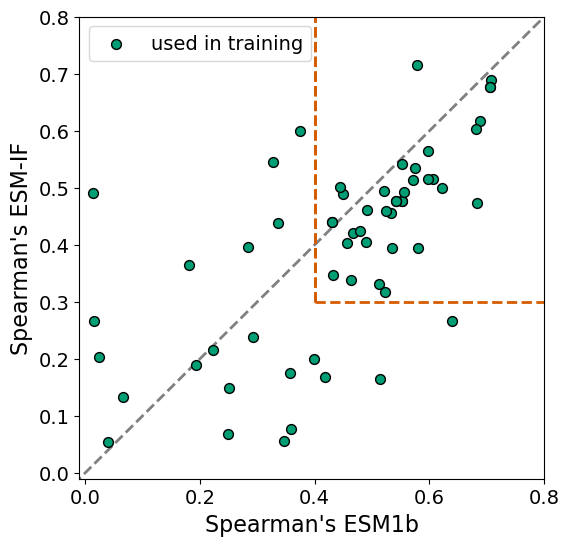

In [23]:
fig,ax=plt.subplots(1,1,figsize=(6,6))

ax.scatter(corr_dms_df['sp_1b'].to_numpy(),corr_dms_df['sp_if'].to_numpy(),facecolor='#009e74',edgecolor='k',s=50,label = 'used in training')

ax.set_xlim(-0.01,0.8)
ax.set_ylim(-0.01,0.8)
ax.set_xlabel("Spearman's ESM1b")
ax.set_ylabel("Spearman's ESM-IF")

ax.plot([0.4,1],[0.3,0.3],'--',c='#d55c00',lw=2)
ax.plot([0.4,0.4],[0.3,1],'--',c='#d55c00',lw=2)
ax.plot([0.4,0.4],[0.3,1],'--',c='#d55c00',lw=2)
ax.plot([-0.02,1],[-0.02,1],'--',c='gray',lw=2,zorder=-10)

ax.legend()

#plt.savefig('../figures/correlation_with_protgym.pdf')

### Create train/test set for optimising threshold

In [24]:
corr_dms_df_quality=corr_dms_df.query("sp_1b > 0.4 & sp_if >0.3 & sp_1b >sp_if")

In [25]:
training_dms=corr_dms_df_quality['dms_name'].to_numpy()

In [26]:
result_correlation=[]

X_pg_all=[]
Y_pg_all=[]

for i,dms in enumerate(training_dms):
    print(dms)
    training_id=pg_info_notvirus_nostab_train_df.query('DMS_id == @dms')['UniProt_ID'].to_numpy()[0]
    training_seq=pg_info_notvirus_nostab_train_df.query('DMS_id == @dms')['target_seq'].to_numpy()[0]
    try:
        file_esm1b=glob(dir_esm1b+'/*_'+training_id+'_*.txt')[0]
        wt_esm1b=prism_extract_WT_sequence(file_esm1b)
        
        file_exp=glob(dir_exp+'/'+dms+'*.csv')[0]
        
    except:
        print('Input data not found!')
        
    
    if training_seq != wt_esm1b:
        print('WT sequences are not matching')
        pass
    
    esm1b_sel=load_data(file_esm1b,training_seq)
    dms_sel=load_pg_exp(file_exp,training_seq,'bin')
    dms_extra=load_pg_exp(file_exp,training_seq,'score')
    
    
    idx_1b = np.isfinite(esm1b_sel.flatten()) & np.isfinite(dms_sel.flatten())
    
    tmp_X=list(esm1b_sel.flatten()[idx_1b])
    tmp_Y=list(dms_sel.flatten()[idx_1b])
    X_pg_all=X_pg_all+tmp_X
    Y_pg_all=Y_pg_all+tmp_Y

A4GRB6_PSEAI_Chen_2020
AACC1_PSEAI_Dandage_2018
ADRB2_HUMAN_Jones_2020
AMIE_PSEAE_Wrenbeck_2017
BLAT_ECOLX_Deng_2012
BLAT_ECOLX_Firnberg_2014
BLAT_ECOLX_Jacquier_2013
BLAT_ECOLX_Stiffler_2015
BRCA1_HUMAN_Findlay_2018
Input data not found!
WT sequences are not matching
CCDB_ECOLI_Adkar_2012
CCDB_ECOLI_Tripathi_2016
DLG4_RAT_McLaughlin_2012
DYR_ECOLI_Thompson_plusLon_2019
GCN4_YEAST_Staller_induction_2018
IF1_ECOLI_Kelsic_2016
KCNH2_HUMAN_Kozek_2020
Input data not found!
WT sequences are not matching
KKA2_KLEPN_Melnikov_2014
MTH3_HAEAE_Rockah-Shmuel_2015
P53_HUMAN_Giacomelli_NULL_Etoposide_2018
P53_HUMAN_Giacomelli_NULL_Nutlin_2018
P53_HUMAN_Giacomelli_WT_Nutlin_2018
P53_HUMAN_Kotler_2018
WT sequences are not matching
P84126_THETH_Chan_2017
PABP_YEAST_Melamed_2013
Q59976_STRSQ_Romero_2015
SC6A4_HUMAN_Young_2021
SCN5A_HUMAN_Glazer_2019
Input data not found!
WT sequences are not matching
SRC_HUMAN_Ahler_CD_2019
TPMT_HUMAN_Matreyek_2018
TRPC_SACS2_Chan_2017
TRPC_THEMA_Chan_2017
YAP1_HUMAN_A

In [27]:
X_pg_all=np.array(X_pg_all)

Y_pg_all=1-np.array(Y_pg_all,dtype=int)

print('total training points:',len(X_pg_all))

total training points: 120600


### selecting threshold via ROC analysis

In [28]:
kfold=RepeatedStratifiedKFold(n_splits=4,n_repeats=1,random_state=1)

In [29]:
for train_index, test_index in kfold.split(X_pg_all, Y_pg_all):

    X_train, X_test = X_pg_all[train_index], X_pg_all[test_index]
    Y_train, Y_test = Y_pg_all[train_index], Y_pg_all[test_index]
    
    tpr,fpr,thresholds = roc_curve(Y_train,X_train)
    
    ##  Youden’s J statistic   
    J = tpr - fpr
    print(auc(fpr,tpr),thresholds[np.argmax(J)])
    tpr,fpr,thresholds = roc_curve(Y_test,X_test)
    
    

0.7759057731599365 -5.835289001464844
0.7763310517474388 -5.790928840637207
0.7771518466170807 -5.789756774902344
0.7745921569015485 -5.790928840637207


In [30]:
tpr,fpr,thresholds = roc_curve(Y_pg_all,X_pg_all)
##  Youden’s J statistic    
J = tpr - fpr

Text(0, 0.5, 'True Positive Rate')

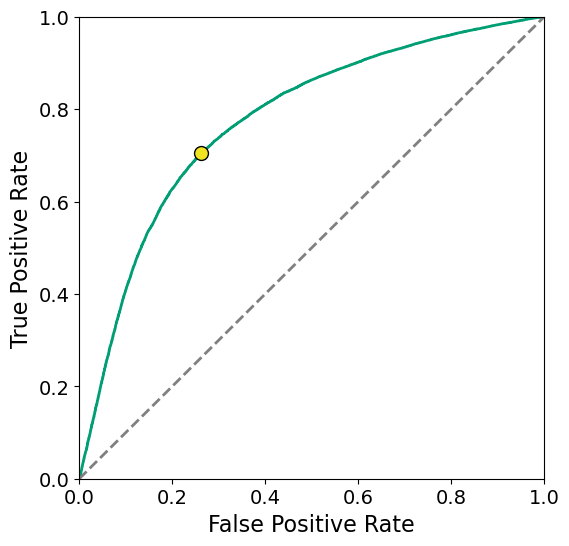

In [31]:
fig,ax=plt.subplots(1,1,figsize=(6,6))

ax.plot(
    fpr,
    tpr,
    color="#009e74",
    lw=2,
)
ax.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
ax.scatter(fpr[np.argmax(J)],tpr[np.argmax(J)],s=100,edgecolor='k',facecolor='#f0e422',zorder=100)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

#plt.savefig('../figures/auc_esm1b_protgym.pdf')

## ESM-IF - evaluate optimal threshold
### load data Tsuboyama 2023

upload and filter data in input

<b><font color='#d55c00'>N.B. Tsuboyama2023_Dataset2_Dataset3_20230416.csv IS NOT INCLUDED and needs to be downloaded from the original source and add to the data folder</font></b>

In [32]:
#rockin_data_df=pd.read_csv('../../../../../postdoc_cph_projects/test_esm_if/Tsuboyama2023_Dataset2_Dataset3_20230416.csv') ## local path
rockin_data_df=pd.read_csv('../data/data_train_validation_func_esms/Tsuboyama2023_Dataset2_Dataset3_20230416.csv') ## load csv from Tsuboyama2023: Tsuboyama2023_Dataset2_Dataset3_20230416.csv

In [33]:
target_pdbs=[]
for idx,row in rockin_data_df.iterrows():
    if row['mut_type'] == 'wt' or not (':' in row['mut_type'] or 'del' in row['mut_type'] or 'ins' in row['mut_type']) :
        if not row['WT_name'] in target_pdbs:
            
            target_pdbs.append(row['WT_name'])

In [34]:
target_real_pdbs=[]
for elem in target_pdbs:
    if len(elem) == 8:
        target_real_pdbs.append(elem[:4])  

In [35]:
tmp=rockin_data_df[ rockin_data_df['mut_type'].str.contains('ins')==False ]

In [36]:
tmp=tmp[tmp['mut_type'].str.contains('del')==False ]

In [37]:
rockin_data_df_filtered=tmp[tmp['mut_type'].str.contains(':')==False]

### pair Tsuboyama ddG with ESM-IF marginal score

In [38]:
score_marg=[]
score_exp_ddg=[]
score_spearmanr=[]
dir_sel=os.path.abspath('../data/data_train_validation_func_esms/esm_if/Tsuboyama_IF_scores/')
for idx,pdb_sel in enumerate(target_pdbs[:]):
    if (idx+1)%100 ==0:
        print('# processed: ',idx+1)
    if len(pdb_sel)==8:
        try:
            sel_score_marg=[]
            sel_exp_ddg=[]
            #try:
            df_sel=rockin_data_df_filtered[rockin_data_df_filtered['WT_name'] == pdb_sel]
            seq_sel=df_sel['aa_seq'].iloc[0]
            if len(glob(dir_sel+'/*'+pdb_sel[:-4]+'*marginals*')) ==1:
                marg_file=glob(dir_sel+'/*'+pdb_sel[:-4]+'*marginals*')[0]
            data_marg=load_data(marg_file,seq_sel)
            for idx,row in df_sel.iterrows():
                if row['mut_type'] =='wt':
                    pass
                else:
                    if row['ddG_ML'] !='-':
                        sel_score_marg.append(data_marg[int(row['mut_type'][1:-1])-1,alphabetAA_L_D[row['mut_type'][-1]]-1])
                        sel_exp_ddg.append(float(row['ddG_ML']))

            score_spearmanr.append(sp.stats.pearsonr(sel_score_marg,sel_exp_ddg)[0])           
            
            if sel_exp_ddg !=[]:
                score_exp_ddg=score_exp_ddg+sel_exp_ddg            
                score_marg=score_marg+sel_score_marg
        except:
            pass

# processed:  100
# processed:  200
# processed:  300
# processed:  400


In [39]:
### plot correlation

PearsonRResult(statistic=0.6165961980910912, pvalue=0.0)


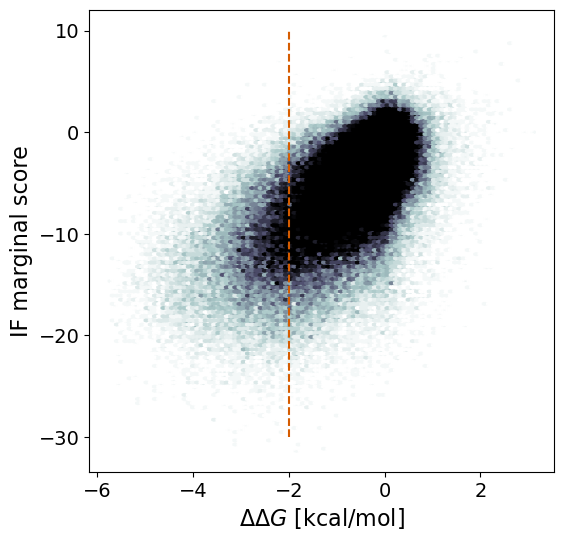

In [40]:
score_exp_ddg=np.array(score_exp_ddg)
score_marg=np.array(score_marg)
score_spearmanr=np.array(score_spearmanr)
fig,ax1=plt.subplots(1,1,figsize=(6,6))
ax1.hexbin(score_exp_ddg, score_marg, gridsize=(100,100), cmap='bone_r',vmin=0,vmax=30)
ax1.set_xlabel(r'$\Delta \Delta G$ [kcal/mol]')
ax1.set_ylabel('IF marginal score')
ax1.plot([-2,-2],[-30,10],'--',c='#d55c00')
print(sp.stats.pearsonr(score_exp_ddg, score_marg))
#plt.savefig('../figures/corr_if_rocklin.pdf')

### selecting optimal threshold using ROC analysis

In [41]:
X_rock_all=np.array(score_marg)

In [42]:
Y_rock_all=np.array([0 if i > -2.5 else 1 for i in score_exp_ddg])

In [43]:
kfold=RepeatedStratifiedKFold(n_splits=4,n_repeats=1,random_state=1)

In [44]:
for train_index, test_index in kfold.split(X_rock_all, Y_rock_all):

    X_train, X_test = X_rock_all[train_index], X_rock_all[test_index]
    Y_train, Y_test = Y_rock_all[train_index], Y_rock_all[test_index]
    
    tpr,fpr,thresholds = roc_curve(Y_train,X_train)
    
    ##  Youden’s J statistic   
    J = tpr - fpr
    
    print(auc(fpr,tpr),thresholds[np.argmax(J)])
    
    tpr,fpr,thresholds = roc_curve(Y_test,X_test)
    
    

0.8663449896973413 -7.537968635559082
0.8666293936455443 -7.537968635559082
0.8688548244856112 -7.524503231048584
0.8670700655136347 -7.542448997497559


In [45]:
tpr,fpr,thresholds = roc_curve(Y_rock_all,X_rock_all)
##  Youden’s J statistic    
J = tpr - fpr

Text(0, 0.5, 'True Positive Rate')

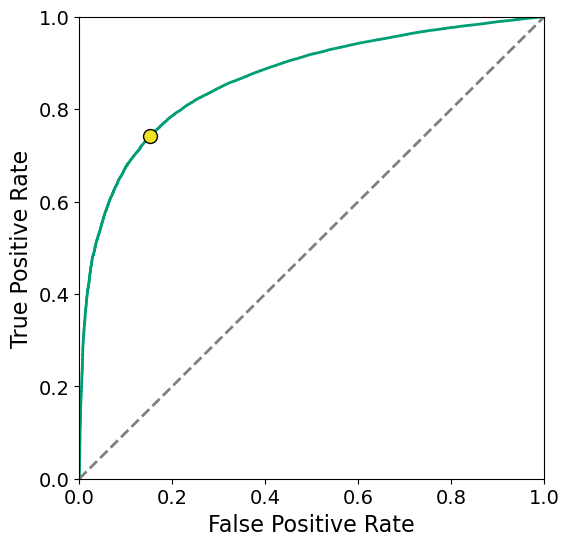

In [46]:
fig,ax=plt.subplots(1,1,figsize=(6,6))

ax.plot(
    fpr,
    tpr,
    color="#009e74",
    lw=2,
)
ax.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")
ax.scatter(fpr[np.argmax(J)],tpr[np.argmax(J)],s=100,edgecolor='k',facecolor='#f0e422',zorder=100)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

#plt.savefig('../figures/auc_esm1b_esmif.pdf')

## Validation of FunC-ESMs

### NUDT15

In [47]:
NUDT15_WT_sequence="MTASAQPRGRRPGVGVGVVVTSCKHPRCVLLGKRKGSVGAGSFQLPGGHLEFGETWEECAQRETWEEAALHLKNVHFASVVNSFIEKENYHYVTILMKGEVDVTHDSEPKNVEPEKNESWEWVPWEELPPLDQLFWGLRCLKEQGYDPFKEDLNHLVGYKGNHL"

#### Load experimental data

In [48]:
df=pd.read_excel('../data/data_train_validation_func_esms/exp_score/NUDT15_Suiter_2020.xlsx', index_col=0,header=2)
mutation_load=np.array(df.iloc[:,2])
mutation_position=np.array(df.iloc[:,3])
score_funct=np.array(df.iloc[:,7])
score_abund=np.array(df.iloc[:,5])

In [49]:
NUDT15_abundance=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
NUDT15_abundance[:]=np.nan

In [50]:
for i in range(len(mutation_load)):
    if score_abund[i] != ' NA':
        NUDT15_abundance[int(mutation_position[i])-1, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]=float(score_abund[i])

In [51]:
NUDT15_function=np.empty((len(NUDT15_WT_sequence),20),dtype=float)
NUDT15_function[:]=np.nan

In [52]:
for i in range(len(mutation_load)):
    if score_funct[i] != ' NA':
        NUDT15_function[int(mutation_position[i])-1, alphabetAA_L_D[mutation_load[i][len(mutation_load[i])-1]]-1]=float(score_funct[i])

#### Load computational data

In [53]:
NUDT15_ESM_1b_scores=load_data('../data/data_train_validation_func_esms/esm_1b/prism_Q9NV35_ESM.txt',NUDT15_WT_sequence)

In [54]:
NUDT15_IF=load_data('../data/data_train_validation_func_esms/esm_if/prism_ESM-IF_Q9NV35_marginals.txt',NUDT15_WT_sequence)

### CYP2C9

In [55]:
CYP2C9_WT_sequence="MDSLVVLVLCLSCLLLLSLWRQSSGRGKLPPGPTPLPVIGNILQIGIKDISKSLTNLSKVYGPVFTLYFGLKPIVVLHGYEAVKEALIDLGEEFSGRGIFPLAERANRGFGIVFSNGKKWKEIRRFSLMTLRNFGMGKRSIEDRVQEEARCLVEELRKTKASPCDPTFILGCAPCNVICSIIFHKRFDYKDQQFLNLMEKLNENIKILSSPWIQICNNFSPIIDYFPGTHNKLLKNVAFMKSYILEKVKEHQESMDMNNPQDFIDCFLMKMEKEKHNQPSEFTIESLENTAVDLFGAGTETTSTTLRYALLLLLKHPEVTAKVQEEIERVIGRNRSPCMQDRSHMPYTDAVVHEVQRYIDLLPTSLPHAVTCDIKFRNYLIPKGTTILISLTSVLHDNKEFPNPEMFDPHHFLDEGGNFKKSKYFMPFSAGKRICVGEALAGMELFLFLTSILQNFNLKSLVDPKNLDTTPVVNGFASVPPFYQLCFIPV"

#### Load experimental data

In [56]:
df=pd.read_csv('../data/data_train_validation_func_esms/exp_score/CYP2C9_Amorosi_2021_AMJhumGenet.csv',sep=',')
mutation_load=np.array(df.iloc[:,0])
score_funct=np.array(df.iloc[:,6])
score_abund=np.array(df.iloc[:,17])

In [57]:
CYP2C9_abundance=np.empty((len(CYP2C9_WT_sequence),20),dtype=float)
CYP2C9_abundance[:]=np.nan

In [58]:
for i in range(len(mutation_load)):
    if score_abund[i] != 'NaN' and (mutation_load[i][-1:])!='~' and mutation_load[i][-1:]!='*' and mutation_load[i][-1:]!='X' and mutation_load[i] !="WT":
        CYP2C9_abundance[int(mutation_load[i][1:-1])-1, alphabetAA_L_D[mutation_load[i][-1:]]-1]=float(score_abund[i])

In [59]:
CYP2C9_function=np.empty((len(CYP2C9_WT_sequence),20),dtype=float)
CYP2C9_function[:]=np.nan

In [60]:
for i in range(len(mutation_load)):
    if score_funct[i] != 'NaN' and (mutation_load[i][-1:])!='~' and mutation_load[i][-1:]!='*' and mutation_load[i][-1:]!='X' and mutation_load[i] !="WT":
        CYP2C9_function[int(mutation_load[i][1:-1])-1, alphabetAA_L_D[mutation_load[i][-1:]]-1]=float(score_funct[i])

#### Load computational data


In [61]:
CYP2C9_ESM_1b_scores=load_data('../data/data_train_validation_func_esms/esm_1b/prism_P11712_ESM.txt',CYP2C9_WT_sequence)

In [62]:
CYP2C9_IF=load_data('../data/data_train_validation_func_esms/esm_if/prism_ESM-IF_P11712_marginals.txt',CYP2C9_WT_sequence)

### PTEN

In [63]:
PTEN_WT_sequence="MTAIIKEIVSRNKRRYQEDGFDLDLTYIYPNIIAMGFPAERLEGVYRNNIDDVVRFLDSKHKNHYKIYNLCAERHYDTAKFNCRVAQYPFEDHNPPQLELIKPFCEDLDQWLSEDDNHVAAIHCKAGKGRTGVMICAYLLHRGKFLKAQEALDFYGEVRTRDKKGVTIPSQRRYVYYYSYLLKNHLDYRPVALLFHKMMFETIPMFSGGTCNPQFVVCQLKVKIYSSNSGPTRREDKFMYFEFPQPLPVCGDIKVEFFHKQNKMLKKDKMFHFWVNTFFIPGPEETSEKVENGSLCDQEIDSICSIERADNDKEYLVLTLTKNDLDKANKDKANRYFSPNFKVKLYFTKTVEEPSNPEASSSTSVTPDVSDNEPDHYRYSDTTDSDPENEPFDEDQHTQITKV"

#### Load experimental data

In [64]:
df=pd.read_csv('../data/data_train_validation_func_esms/exp_score/PTEN_VAMP_Matreyek_2018_NatGenet.csv',sep=',')
mutation_load=np.array(df.iloc[:,2],dtype=str)
score_abund=np.array(df.iloc[:,3])

In [65]:
PTEN_abundance=np.empty((len(PTEN_WT_sequence),20),dtype=float)
PTEN_abundance[:]=np.nan

In [66]:
for i in range(len(mutation_load)):
    if score_abund[i] != 'NaN' and mutation_load[i][-1:]!='=' and alphabetAA_3L_1L[mutation_load[i][-3:]]!='*':  
        PTEN_abundance[int(mutation_load[i][5:-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]=float(score_abund[i])

In [67]:
df = pd.read_excel (r'../data/data_train_validation_func_esms/exp_score/PTEN_MAVE_Mighell_2018_AMJHumGenet.xlsx', sheet_name='scores',header=1)
mutation_load=np.array(df.iloc[:,0])
score_funct=np.array(df.iloc[:,6])

In [68]:
PTEN_function=np.empty((len(PTEN_WT_sequence),20),dtype=float)
PTEN_function[:]=np.nan

In [69]:
for i in range(len(mutation_load)):
    if score_funct[i] != 'NaN' and (mutation_load[i][-1:])!='~' and mutation_load[i][-1:]!='*':
        PTEN_function[int(mutation_load[i][1:-1])-1, alphabetAA_L_D[mutation_load[i][-1:]]-1]=float(score_funct[i])

#### Load computational data


In [70]:
PTEN_ESM_1b_scores=load_data('../data/data_train_validation_func_esms/esm_1b/prism_P60484_ESM.txt',PTEN_WT_sequence)

In [71]:
PTEN_IF=load_data('../data/data_train_validation_func_esms/esm_if/prism_ESM-IF_P60484_marginals.txt',PTEN_WT_sequence)

### SH3

In [72]:
P62993_WT_sequence="MEAIAKYDFKATADDELSFKRGDILKVLNEECDQNWYKAELNGKDGFIPKNYIEMKPHPWFFGKIPRAKAEEMLSKQRHDGAFLIRESESAPGDFSLSVKFGNDVQHFKVLRDGAGKYFLWVVKFNSLNELVDYHRSTSVSRNQQIFLRDIEQVPQQPTYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGMFPRNYVTPVNRNV"
P62993_WT_rosetta ="MEAIAKYDFKATADDELSFKRGDILKVLNEECDQNWYKAELNGKDGFIPKNYIEMKPHPWFFGKIPRAKAEEMLSKQRHDGAFLIRESESAPGDFSLSVKFGNDVQHFKVLRDGAGKYFLWVVKFNSLNELVDYHRSTSVSRNQQIFLRDIEQVPQQPTYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGMFPRNYVTPVNRNV"
P62993_WT_exp     ="--------------------------------------------------------------------------------------------------------------------------------------------------------------TYVQALFDFDPQEDGELGFRRGDFIHVMDNSDPNWWKGACHGQTGMFPRNYVTPVN---"

In [73]:
P62993_exp_starting_pos=158

#### Load experimental data

##### table s6

In [74]:
SI_exp_df=pd.read_csv('../data/data_train_validation_func_esms/exp_score/SH3_Faure_2022_Nature_SI6.txt',sep='\t')

In [75]:
for i,n in SI_exp_df.query('protein == "GRB2-SH3" and WT == True').iterrows():
    P62993_WT_frag_exp=n['aa_seq'][:-1]

In [76]:
P62993_binding=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_binding[:]=np.nan

In [77]:
P62993_abundance=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_abundance[:]=np.nan

In [78]:
for i,n in SI_exp_df.query('protein == "GRB2-SH3" and Nham_aa==1').iterrows():
    count_pos=0
    for l in n['aa_seq'][:-1]:
        if l == P62993_WT_frag_exp[count_pos]:
            count_pos+=1
        else:
            if n['pca_type'] == 'Abundance':
                P62993_abundance[count_pos+P62993_exp_starting_pos,alphabetAA_L_D[l]-1]=float(n['fitness'])
                break
            if n['pca_type'] == 'Binding':
                P62993_binding[count_pos+P62993_exp_starting_pos,alphabetAA_L_D[l]-1]=n['fitness']
                break

In [79]:
P62993_abundance_median=np.nanmedian(P62993_abundance,axis=1)
P62993_binding_median=np.nanmedian(P62993_binding,axis=1)

##### table S8

In [80]:
SI_pred_df=pd.read_excel('../data/data_train_validation_func_esms/exp_score/SH3_Faure_2022_Nature_SI8.xlsx')

In [81]:
P62993_binding_ddg=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_binding_ddg[:]=np.nan


In [82]:
P62993_abundance_ddg=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_abundance_ddg[:]=np.nan


In [83]:
for i,n in SI_pred_df.query('protein == "GRB2-SH3" and mut_order==1').iterrows():
    P62993_binding_ddg[int(n['id_ref'][1:-1])+P62993_exp_starting_pos-1,alphabetAA_L_D[n['id_ref'][-1]]-1]=float(n['b_ddg_pred'])
    P62993_abundance_ddg[int(n['id_ref'][1:-1])+P62993_exp_starting_pos-1,alphabetAA_L_D[n['id_ref'][-1]]-1]=float(n['f_ddg_pred'])


In [84]:
P62993_abundance_ddg_norm=normalize_cutoff(P62993_abundance_ddg,-1,3)
P62993_binding_ddg_norm=normalize_cutoff(P62993_binding_ddg,-1,3)

In [85]:
P62993_abundance_ddg_median=np.nanmedian(P62993_abundance_ddg,axis=1)
P62993_binding_ddg_median=np.nanmedian(P62993_binding_ddg,axis=1)

In [86]:
P62993_exp_variant_label=np.empty((len(P62993_WT_sequence),20),dtype=float)
P62993_exp_variant_label[:]=np.nan

In [87]:
# Assign the color to the variant based on its position in the 2d combined histogram

#wt like = 0
#sbi = 1
#total loss = 2

y_threshold=1
x_threshold=1

for i in range(P62993_exp_variant_label.shape[0]):
    for j in range(P62993_exp_variant_label.shape[1]):
        if np.isnan(P62993_binding_ddg_norm[i,j]) or np.isnan(P62993_abundance_ddg_norm[i,j]):
            pass
        else:
            if P62993_binding_ddg_norm[i,j] <= y_threshold:
                if P62993_abundance_ddg_norm[i,j] <= x_threshold:
                    P62993_exp_variant_label[i,j]=0
                else:
                    P62993_exp_variant_label[i,j]=2
            else:
                if P62993_abundance_ddg_norm[i,j] <= x_threshold:
                    P62993_exp_variant_label[i,j]=1
                else:
                    P62993_exp_variant_label[i,j]=2

In [88]:
P62993_exp_residue_label=np.empty((len(P62993_WT_sequence),1),dtype=float)
P62993_exp_residue_label[:]=np.nan

In [89]:
# Assign the color to the variant based on its position in the 2d combined histogram

#wt like = 0
#sbi = 1
#total loss = 2

y_threshold=1
x_threshold=1

for i in range(P62993_exp_residue_label.shape[0]):
        if np.isnan(P62993_binding_ddg_median[i]) or np.isnan(P62993_abundance_ddg_median[i]):
            pass
        else:
            if P62993_binding_ddg_median[i] <= y_threshold:
                if P62993_abundance_ddg_median[i] <= x_threshold:
                    P62993_exp_residue_label[i]=0
                else:
                    P62993_exp_residue_label[i]=2
            else:
                if P62993_abundance_ddg_median[i] <= x_threshold:
                    P62993_exp_residue_label[i]=1
                else:
                    P62993_exp_residue_label[i]=2

#### Computational Data

In [90]:
P62993_ESM1b_marginals=load_data('../data/data_train_validation_func_esms/esm_1b/prism_P62993_ESM.txt',P62993_WT_sequence)        

In [91]:
P62993_IF=load_data('../data/data_train_validation_func_esms/esm_if/prism_ESM-IF_P62993_AF_marginals.txt',P62993_WT_sequence)

### GCK

In [92]:
consensus_seque='MADDAARRLAALREEVEEILKEFTLSDEKLRKIVDRFLEEMEKGLAKETHDGSSLKMLPTYVTSLPTGTEKGTFLALDLGGTNFRVLLVELKGGGDGKFEVEMEQKKYAIPEELMTGTGEELFDFIADCLADFLEEHGLKGEKLPLGFTFSFPVEQTSLDSGILIRWTKGFDISGVEGKDVVQLLQEALDRRGDLPVDVVALVNDTVGTLMACAYKDPDCEIGLILGTGTNACYMEKLSNIPKLEGDSGEMIINTEWGAFGDDGCLDFPRTEYDRELDRESLNPGKQLFEKMISGMYLGEIVRLVLLDLAKEGLLFGGQSSEKLNTPYSFDTKYLSEIESDSSDLEETREILEELGLEPSLEDRKIVRYVCELVSTRAARLAAAGIAAILKKMGRLRGLDELRVTVGVDGSLYEKYPGFRERLREALRELLPEKKVKLVLAEDGSGVGAALIAAVASRLAEQMEQ'
GCK_SD_cons_seq='---------------IEEILEEFTLSDEQLREIVDRFLEEMEKGLAKEGHPESSLKMLPTYVRSLPTGTEKGDFLALDLGGTNFRVLLVKLGGDGKGQGKVEMEQKKYRIPEELMTGTGEELFDFIADCLADFLEEHGLKDKKLPLGFTFSFPCEQTSLDSGILIRWTKGFKASGVEGKDVVQLLQEAIKRRGLFDVDVVALVNDTVGTLMACAY----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'
GCK_SD_WT_seque='---------------VEQILSEFRLKEEDLRKVMHRMQKEMDRGLKLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWKVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYY----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'
GCK_WT_sequence="MLDDRARMEAAKKEKVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKACMLGQ"
GCK_WT_ros_seq1='--------------MVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRH-----------------------NVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKAC----'
GCK_WT_ros_seq2='-------------TLVEQILAEFQLQEEDLKKVMRRMQKEMDRGLRLETHEEASVKMLPTYVRSTPEGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMVNDTVATMISCYYEDHQCEVGMIVGTGCNACYMEEMQNVELVEGDEGRMCVNTEWGAFGDSGELDEFLLEYDRLVDESSANPGQQLYEKLIGGKYMGELVRLVLLRLVDENLLFHGEASEQLRTRGAFETRFVSQVESDTGDRKQIYNILSTLGLRPSTTDCDIVRRACESVSTRAAHMCSAGLAGVINRMRESRSEDVMRITVGVDGSVYKLHPSFKERFHASVRRLTPSCEITFIESEEGSGRGAALVSAVACKKAC----'
GCK_WT_small_do='------------------------------------------------------------------EGSEVGDFLSLDLGGTNFRVMLVKVGEGEEGQWSVKTKHQMYSIPEDAMTGTAEMLFDYISECISDFLDKHQMKHKKLPLGFTFSFPVRHEDIDKGILLNWTKGFKASGAEGNNVVGLLRDAIKRRGDFEMDVVAMV----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------'

In [93]:
diff_cons_GKC=np.zeros(len(GCK_WT_sequence),dtype=int)

In [94]:
for i,n in enumerate(GCK_WT_sequence):
    if n == consensus_seque[i]:
        diff_cons_GKC[i]=1

#### Load experimental data

In [95]:
df_mave=pd.read_csv('../data/data_train_validation_func_esms/exp_score/GCK_activity_Gersing_2023_GenBiol.csv', sep=',', comment='#')

mutation_load=np.array(df_mave.iloc[:,0])
score_load=np.array(df_mave.iloc[:,1])
errors_load=np.array(df_mave.iloc[:,4])

GCK_activity_scores=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_activity_scores[:]=np.nan

GCK_errors=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_errors[:]=np.nan

for i in range(len(mutation_load)):
    if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][-3:] != 'Ter' :
        GCK_activity_scores[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= float(score_load[i])
        GCK_errors[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= float(errors_load[i])
print(GCK_activity_scores)

[[       nan        nan        nan ...        nan        nan        nan]
 [0.47370882 0.76026135 1.17439486 ... 1.68704651 1.02432969 1.00047111]
 [1.05050524 0.96763201        nan ... 0.52479177 1.54131692 0.96495525]
 ...
 [1.41978183 0.76604617 1.87158453 ... 0.92376059 1.18721564 1.07026878]
 [1.19791722 0.39494738 0.90150363 ... 0.56074835 0.56652803 0.84600014]
 [1.99840705 1.0127656  1.12721214 ... 1.5376213  1.40138102 0.98352022]]


In [96]:
df_mave=pd.read_csv('../data/data_train_validation_func_esms/exp_score/GCK_abudance_Gersing_2024_GenBiol.csv', sep=',', comment='#')

mutation_load=np.array(df_mave.iloc[:,0])
score_load=np.array(df_mave.iloc[:,1])
errors_load=np.array(df_mave.iloc[:,3])

GCK_abundance_scores=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_abundance_scores[:]=np.nan

GCK_abundance_errors=np.empty((len(GCK_WT_sequence),20),dtype=float)
GCK_abundance_errors[:]=np.nan

for i in range(len(mutation_load)):
    if  mutation_load[i][len(mutation_load[i])-1]!= '=' and mutation_load[i][-3:] != 'Ter' :
        GCK_abundance_scores[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= float(score_load[i])
        GCK_abundance_errors[int(mutation_load[i][5:len(mutation_load[i])-3])-1, alphabetAA_L_D[alphabetAA_3L_1L[mutation_load[i][-3:]]]-1]= float(errors_load[i])
print(GCK_abundance_scores)

[[       nan        nan        nan ...        nan        nan        nan]
 [0.84649739 1.01301806 1.13386807 ... 1.10515067 0.6540466  1.03507594]
 [0.72560216 0.61368334        nan ... 0.43192961 0.3836345  0.05354563]
 ...
 [1.08244207 0.96966573 0.91602712 ... 1.02988275 1.00289093        nan]
 [0.75026721 0.76171314 1.168608   ... 0.70328755        nan 0.7304929 ]
 [0.92405485 0.98767745        nan ... 0.63112163 0.75548628 0.77510853]]


In [97]:
GCK_labels=multiclass_threshold(GCK_abundance_scores,GCK_activity_scores,0.66,0.58)


In [98]:
GCK_labels_mode,counts=sp.stats.mode(GCK_labels,axis=1)

#### load computational data

##### functional model

prediction functional model generated via the colab implementation

In [99]:
df_in=pd.read_csv('../data/data_train_validation_func_esms/extra_data/GCK_P35557_FunctionalModel_variant_predictions.csv')

In [100]:
GCK_fm_variants=np.empty((GCK_labels.shape[0],20),dtype=float)
GCK_fm_variants[:]=np.nan

In [101]:
for idx,row in df_in.iterrows():
    if not np.isnan(row['Variant_class_digit']):
        GCK_fm_variants[int(row['Mutation'][1:-1])-1,alphabetAA_L_D[row['Mutation'][-1]]-1]=row['Variant_class_digit']
    

In [102]:
df_in=pd.read_csv('../data/data_train_validation_func_esms/extra_data/GCK_P35557_FunctionalModel_residue_predictions.csv')

In [103]:
GCK_fm_residues=np.empty(GCK_labels_mode.shape[0],dtype=float)
GCK_fm_residues[:]=np.nan

In [104]:
for idx,row in df_in.iterrows():
    if not np.isnan(row['Residue_class_digit']):
        GCK_fm_residues[int(row['Residue'][1:])-1]=row['Residue_class_digit']
    

##### esms

In [105]:
GCK_ESM1b_marginals=load_data('../data/data_train_validation_func_esms/esm_1b/prism_P35557_ESM.txt',GCK_WT_sequence)        

In [106]:
GCK_IF=load_data('../data/data_train_validation_func_esms/esm_if/prism_ESM_IF_P35557_A_marginals.txt',GCK_WT_sequence)

### validation on the three training set of the Functional Model (Cagiada,2023)

#### ALL

In [107]:
NUDT15_labels=multiclass_threshold(NUDT15_abundance,NUDT15_function,0.38,0.51)
PTEN_labels=multiclass_threshold(PTEN_abundance,PTEN_function,0.54,-0.9)
CYP2C9_labels=multiclass_threshold(CYP2C9_abundance,CYP2C9_function,0.38,0.40)

In [108]:
NUDT15_X,NUDT15_Y,NUDT15_map=features_classification([NUDT15_ESM_1b_scores, NUDT15_IF],[NUDT15_labels],NUDT15_WT_sequence)

PTEN_X,PTEN_Y,PTEN_map=features_classification([PTEN_ESM_1b_scores, PTEN_IF],[PTEN_labels],PTEN_WT_sequence)

CYP2C9_X,CYP2C9_Y,CYP2C9_map=features_classification([CYP2C9_ESM_1b_scores,CYP2C9_IF],[CYP2C9_labels],CYP2C9_WT_sequence)


In [109]:
X_test_all=np.concatenate((NUDT15_X,PTEN_X,CYP2C9_X))

Y_test_all=np.concatenate((NUDT15_Y,PTEN_Y,CYP2C9_Y))


In [110]:
Y_variant_pred=esms_model_variant_classes(X_test_all[:,0],X_test_all[:,1],esm1b_t=-6,esmif_t=-7.5)

In [111]:
idx = np.isfinite(Y_test_all.flatten()) & np.isfinite(Y_variant_pred.flatten())

In [112]:
print(classification_report(Y_test_all.flatten()[idx],Y_variant_pred.flatten()[idx], digits=3))

              precision    recall  f1-score   support

         0.0      0.879     0.519     0.653      6399
         1.0      0.210     0.304     0.249      1981
         2.0      0.437     0.835     0.573      1895

    accuracy                          0.536     10275
   macro avg      0.509     0.553     0.492     10275
weighted avg      0.668     0.536     0.560     10275



#### only PTEN

In [113]:
Y_variant_pred=esms_model_variant_classes(PTEN_X[:,0],PTEN_X[:,1],esm1b_t=-6.5,esmif_t=-7.0)

In [114]:
idx = np.isfinite(np.array(PTEN_Y).flatten()) & np.isfinite(Y_variant_pred.flatten())

In [115]:
print(classification_report(np.array(PTEN_Y).flatten()[idx],Y_variant_pred.flatten()[idx], digits=3))

              precision    recall  f1-score   support

         0.0      0.827     0.441     0.575      2102
         1.0      0.209     0.338     0.258       720
         2.0      0.474     0.836     0.605       703

    accuracy                          0.498      3525
   macro avg      0.503     0.538     0.479      3525
weighted avg      0.630     0.498     0.516      3525



#### only NUDT15

In [116]:
Y_variant_pred=esms_model_variant_classes(NUDT15_X[:,0],NUDT15_X[:,1],esm1b_t=-6.5,esmif_t=-7.0)

In [117]:
idx = np.isfinite(np.array(NUDT15_Y).flatten()) & np.isfinite(Y_variant_pred.flatten())

In [118]:
print(classification_report(np.array(NUDT15_Y).flatten()[idx],Y_variant_pred.flatten()[idx], digits=3))

              precision    recall  f1-score   support

         0.0      0.968     0.686     0.803      1708
         1.0      0.252     0.506     0.336       265
         2.0      0.513     0.808     0.628       401

    accuracy                          0.687      2374
   macro avg      0.578     0.667     0.589      2374
weighted avg      0.811     0.687     0.721      2374



#### only CYP2C9

In [119]:
Y_variant_pred=esms_model_variant_classes(CYP2C9_X[:,0],CYP2C9_X[:,1],esm1b_t=-6.5,esmif_t=-7.0)

In [120]:
idx = np.isfinite(np.array(CYP2C9_Y).flatten()) & np.isfinite(Y_variant_pred.flatten())

In [121]:
print(classification_report(np.array(CYP2C9_Y).flatten()[idx],Y_variant_pred.flatten()[idx], digits=3))

              precision    recall  f1-score   support

         0.0      0.829     0.584     0.685      2589
         1.0      0.199     0.147     0.169       996
         2.0      0.378     0.870     0.527       791

    accuracy                          0.536      4376
   macro avg      0.469     0.533     0.460      4376
weighted avg      0.604     0.536     0.539      4376



### validation on SH3

In [122]:
P62993_X,P62993_Y,P62993_map=features_classification([P62993_ESM1b_marginals, P62993_IF],[P62993_exp_variant_label],P62993_WT_sequence)


In [123]:
Y_variant_pred=esms_model_variant_classes(P62993_X[:,0],P62993_X[:,1],esm1b_t=-6.5,esmif_t=-7)

In [124]:
idx = np.isfinite(np.array(P62993_Y).flatten()) & np.isfinite(Y_variant_pred.flatten())

In [125]:
print(classification_report(np.array(P62993_Y).flatten()[idx],Y_variant_pred.flatten()[idx], digits=3))

              precision    recall  f1-score   support

         0.0      0.833     0.735     0.781       388
         1.0      0.239     0.585     0.339        65
         2.0      0.831     0.700     0.760       303

    accuracy                          0.708       756
   macro avg      0.635     0.673     0.627       756
weighted avg      0.781     0.708     0.734       756



In [126]:
Y_variant_detr=np.zeros(Y_variant_pred.shape[0],dtype=int)
for idx,Y_pred in enumerate(Y_variant_pred):
    if np.isnan(Y_pred):
        Y_variant_detr[idx]=np.nan
    else:
        if Y_pred !=0:
            Y_variant_detr[idx]=1

In [127]:
P62993_Y_detr=np.zeros(np.array(P62993_Y).shape[0],dtype=int)
for idx,Y_pred in enumerate(P62993_Y):
    if np.isnan(Y_pred):
        P62993_Y_detr[idx]=np.nan
    else:
        if Y_pred[0] !=0:
            P62993_Y_detr[idx]=1

In [128]:
idx = np.isfinite(np.array(P62993_Y_detr).flatten()) & np.isfinite(Y_variant_detr.flatten())

In [129]:
print(classification_report(np.array(P62993_Y_detr).flatten()[idx],Y_variant_detr.flatten()[idx], digits=3))

              precision    recall  f1-score   support

           0      0.833     0.735     0.781       388
           1      0.751     0.845     0.795       368

    accuracy                          0.788       756
   macro avg      0.792     0.790     0.788       756
weighted avg      0.793     0.788     0.788       756



In [130]:
Y_res_pred,_=retrieve_residue_label_pred(Y_variant_pred,P62993_map,P62993_WT_sequence,0.50)

In [131]:
idx = np.isfinite(np.array(P62993_exp_residue_label).flatten()) & np.isfinite(Y_res_pred.flatten())

In [132]:
print(classification_report(np.array(P62993_exp_residue_label).flatten()[idx],Y_res_pred.flatten()[idx], digits=3))

              precision    recall  f1-score   support

         0.0      0.900     0.643     0.750        28
         1.0      0.333     0.800     0.471         5
         2.0      0.857     0.783     0.818        23
         5.0      0.000     0.000     0.000         0

    accuracy                          0.714        56
   macro avg      0.523     0.556     0.510        56
weighted avg      0.832     0.714     0.753        56



### Plot and comparison with Functional Model

N.B. data for the functional model has been collected from the SI of Cagiada,2023 - Ncomms

#### training set

In [133]:
model_name=['functional model','FunC-ESMs model']
NUDT15_F1=[0.27,0.35]
PTEN_F1=[0.13, 0.26]
CYP2C9_F1=[0.32,0.21]

In [134]:
training_pd_stats=pd.DataFrame({'NUDT15':NUDT15_F1,'PTEN':PTEN_F1,'CYP2C9':CYP2C9_F1},index=model_name)
training_pd_stats_T=training_pd_stats.T


(0.0, 0.5)

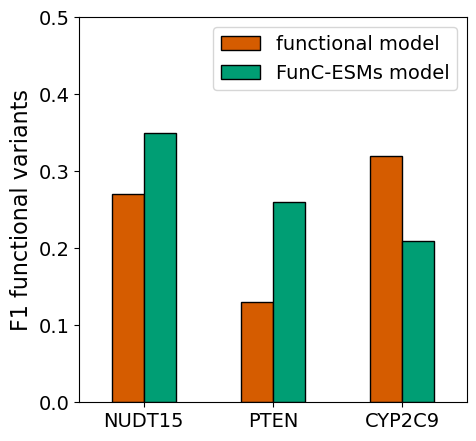

In [135]:
fig,ax1=plt.subplots(1,figsize=(5,5))
training_pd_stats_T.plot.bar(rot=0,ax=ax1,edgecolor='k',color=['#d55c00','#009e74'])
ax1.set_ylabel('F1 functional variants')
ax1.set_ylim(0,0.50)

#plt.savefig('../figures/benchmark_with_fm_trainingset.pdf')

#### SH3

In [136]:
model_name=['GEMME-Rosetta','functional_model','Func-ESMs model']
v_precision_SH3_funct=[0.33,0.25,0.25]
v_recall_SH3_func=[0.30,0.500,0.55]
v_F1_SH3_func=[0.31,0.32,0.34]
v_F1_SH3_all=[0.65,0.67,0.74]
r_F1_SH3_func=[0.40,0.61,0.55]
r_F1_SH3_all=[0.7,0.75,0.76]

In [137]:
SH3_pd_stats=pd.DataFrame({'v_precision_SH3_funct':v_precision_SH3_funct,
                                'v_recall_SH3_func':v_recall_SH3_func,
                                'v_F1_SH3_func':v_F1_SH3_func,
                                'v_F1_SH3_all':v_F1_SH3_all,
                                'r_F1_SH3_func':r_F1_SH3_func,
                                'r_F1_SH3_all':r_F1_SH3_all
                               },index=model_name)
SH3_pd_stats_T=training_pd_stats.T


<Axes: >

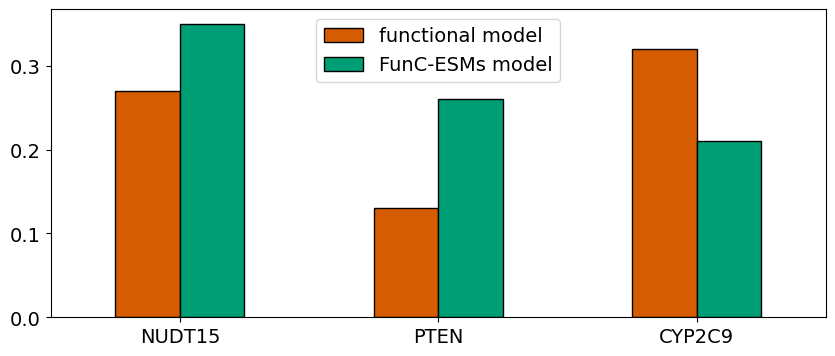

In [138]:
fig,ax1=plt.subplots(1,figsize=(10,4))
SH3_pd_stats_T.plot.bar(rot=0,ax=ax1,edgecolor='k',color=['#d55c00','#009e74','#56b4e9'])
#plt.savefig('../figures/benchmark_with_fm_SH3.pdf')

### GCK

In [139]:
GCK_X,GCK_Y,GCK_map=features_classification([GCK_ESM1b_marginals, GCK_IF],[GCK_labels],GCK_WT_sequence)


In [140]:
GCK_variant_pred=esms_model_variant_classes(GCK_X[:,0],GCK_X[:,1],esm1b_t=-6.5,esmif_t=-7)

In [141]:
GCK_variant_pred=esms_model_variant_classes(GCK_X[:,0],GCK_X[:,1],esm1b_t=-9,esmif_t=-9)

In [142]:
GCK_res_pred,_=retrieve_residue_label_pred(GCK_variant_pred,GCK_map,GCK_WT_sequence,0.50)

#### Comparison FM vs FunC-ESMs

##### fm

In [143]:
idx = np.isfinite(np.array(GCK_labels).flatten()) & np.isfinite(GCK_fm_variants.flatten())

In [144]:
print(classification_report(np.array(GCK_labels).flatten()[idx],GCK_fm_variants.flatten()[idx], digits=3))

              precision    recall  f1-score   support

         0.0      0.628     0.798     0.702      2738
         1.0      0.459     0.350     0.397      2254
         2.0      0.607     0.542     0.573      1915

    accuracy                          0.581      6907
   macro avg      0.565     0.563     0.557      6907
weighted avg      0.567     0.581     0.567      6907



In [145]:
idx = np.isfinite(np.array(GCK_labels_mode).flatten()) & np.isfinite(GCK_fm_residues.flatten())

In [146]:
print(classification_report(np.array(GCK_labels_mode).flatten()[idx],GCK_fm_residues.flatten()[idx], digits=3))

              precision    recall  f1-score   support

         0.0      0.798     0.854     0.825       171
         1.0      0.506     0.359     0.420       117
         2.0      0.615     0.632     0.623       106
         5.0      0.000     0.000     0.000         0

    accuracy                          0.647       394
   macro avg      0.480     0.461     0.467       394
weighted avg      0.662     0.647     0.650       394



##### FunC-ESMs

In [147]:
idx = np.isfinite(np.array(GCK_Y).flatten()) & np.isfinite(GCK_variant_pred.flatten())

In [148]:
print(classification_report(np.array(GCK_Y).flatten()[idx],GCK_variant_pred.flatten()[idx], digits=3))

              precision    recall  f1-score   support

         0.0      0.668     0.709     0.688      2965
         1.0      0.414     0.342     0.375      2284
         2.0      0.539     0.599     0.567      1922

    accuracy                          0.563      7171
   macro avg      0.540     0.550     0.543      7171
weighted avg      0.552     0.563     0.556      7171



In [149]:
idx = np.isfinite(np.array(GCK_labels_mode).flatten()) & np.isfinite(GCK_res_pred.flatten())

In [150]:
print(classification_report(np.array(GCK_labels_mode).flatten()[idx],GCK_res_pred.flatten()[idx], digits=3))

              precision    recall  f1-score   support

         0.0      0.881     0.719     0.792       185
         1.0      0.473     0.376     0.419       117
         2.0      0.545     0.632     0.585       106
         5.0      0.000     0.000     0.000         0

    accuracy                          0.598       408
   macro avg      0.475     0.432     0.449       408
weighted avg      0.677     0.598     0.631       408



#### results and plots

In [151]:
model_name=['Functional model','FunC-ESMs model']
v_precision_GCK_funct=[0.46,0.42]
v_recall_GCK_func=[0.35,0.34]
v_F1_GCK_func=[0.40,0.38]
v_F1_GCK_all=[0.567,0.556]
r_F1_GCK_func=[0.42,0.42]
r_F1_GCK_all=[0.65,0.63]

In [152]:
GCK_pd_stats=pd.DataFrame({#'v_precision_GCK_funct':v_precision_GCK_funct,
                                #'v_recall_GCK_func':v_recall_GCK_func,
                                'v_F1_GCK_func':v_F1_GCK_func,
                                'v_F1_GCK_all':v_F1_GCK_all,
                                'r_F1_GCK_func':r_F1_GCK_func,
                                'r_F1_GCK_all':r_F1_GCK_all
                               },index=model_name)
GCK_pd_stats_T=GCK_pd_stats.T


<Axes: >

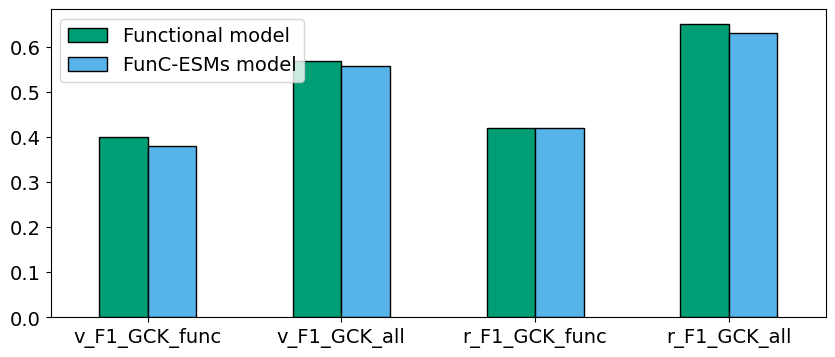

In [153]:
fig,ax1=plt.subplots(1,figsize=(10,4))
GCK_pd_stats_T.plot.bar(rot=0,ax=ax1,edgecolor='k',color=['#009e74','#56b4e9'])
#plt.savefig('../figures/benchmark_with_fm_GCK.pdf')